# Stock Price Predictions using Machine Learning

In this project, I've implemented a Recurrent Neural Network with an [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) architecture to predict future stock prices, by training the model on more than 10 years of historical prices. 

The historical prices from January 2005 to May 2017 of these following stocks are located in the `datasets/` folder of this repository:
- AAPL (Apple)
- AMZN (Amazon)
- BRK-A (Berkshire Hathaway)
- GOOG (Google)
- IBM 
- SPY (S&P 500 tracker)

In [1]:
#importing some useful packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

### Reading and Plotting Stock Data
Read dataset into a pandas dataframe

In [2]:
path_to_data = 'datasets/AAPL.csv'
dataset = pd.read_csv(path_to_data)

Print 5 last rows of the dataset

In [3]:
print(dataset.tail())

            Date        Open        High         Low       Close   Adj Close  \
3117  2017-05-22  154.000000  154.580002  152.910004  153.990005  153.990005   
3118  2017-05-23  154.899994  154.899994  153.309998  153.800003  153.800003   
3119  2017-05-24  153.839996  154.169998  152.669998  153.339996  153.339996   
3120  2017-05-25  153.729996  154.350006  153.029999  153.869995  153.869995   
3121  2017-05-26  154.000000  154.240005  153.309998  153.610001  153.610001   

        Volume  
3117  22966400  
3118  19918900  
3119  19178000  
3120  19235600  
3121  21701100  


The `Adj Close` column displays the stock price at the end of each day, adjusted for splits, etc. This is the variable that interests us

In [4]:
price = pd.read_csv(path_to_data, index_col='Date', parse_dates=True,
                         usecols=['Date','Adj Close'], na_values=['nan'])
price = price.rename(columns={'Adj Close': 'Price'})

Let's plot all the price values of that stock

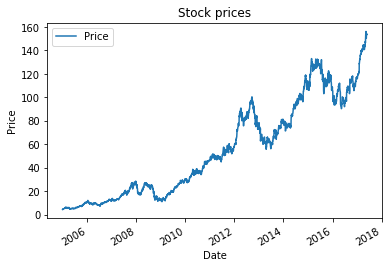

In [5]:
ax = price.plot(title='Stock prices')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

Let's normalize the historical prices to train the Neural Network later

In [6]:
price_norm=(price-price.mean())/price.std()

###  Cutting our time series into sequences

Our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="images/timeseries_windowing_training.gif" width=600 height=600/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Each input is a sequence (or vector) of length 5 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

The following function runs a sliding window along the input series and creates associated input/output pairs. The function inputs a) the series and b) the window length, and return the input/output subsequences. 

In [7]:
def window_transform_series(series, window_size):
    # containers for input/output pairs
    X = []
    y = []

    for n in range(0, len(series)-window_size):
        X.append(series[n:n+window_size])
        y.append(series[n+window_size])

    # reshape each 
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)

    return X,y

Here, I apply the `window_transform_series` function to the normalized stock prices after setting the `window_size`

In [8]:
price_array = np.array(price_norm.iloc[:,0])
window_size = 7
X,y = window_transform_series(series = price_array,window_size = window_size)

### Splitting into training and testing sets

In order to perform proper testing on our dataset, we will split it into 2 subsets.  Once we train our model on the first subset, we will be able to test it on the last subset.

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a normal (non time serie) regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series, and validate on a later chunk as this simulates how we would predict *future* values of a time series.

In [9]:
# set the number of days for which you want to predict the stock price 
days_to_predict = 30

# partition the training set
X_train = X[:-days_to_predict,:]
y_train = y[:-days_to_predict]

# keep the last chunk for testing
X_test = X[-days_to_predict:,:]
y_test = y[-days_to_predict:]

# to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

### Build and Train an RNN regression model

Build Neural Network with Keras

In [10]:
# import keras network libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

model = None
model = Sequential()
model.add(LSTM(5, input_shape=(window_size,1)))
model.add(Dense(1))

optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss='mean_squared_error', optimizer=optimizer)

Using TensorFlow backend.


Train the model and save the weights

In [11]:
model.fit(X_train, y_train, epochs=1000, batch_size=50, verbose=0)

model.save_weights('model_weights/best_RNN_stock_weights.hdf5')

Load weights if you already have saved weights

In [12]:
model.load_weights('model_weights/best_RNN_stock_weights.hdf5')

### Checking model performance
Print out training and testing errors

In [13]:
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

training error = 0.000694030897207
testing error = 0.002368100686


### Make Predictions and Visualize

Let's make predictions on both our training and testing sets.

In [14]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

Plot the original data, as well as the predictions on the testing set. 

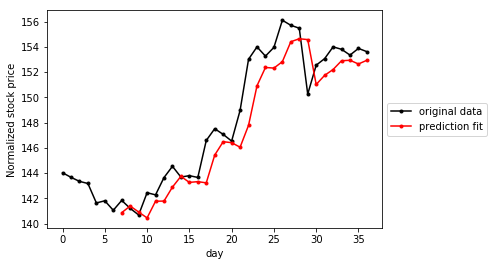

In [15]:
# plot original series
price_scaled=price_array*float(price.std()) + float(price.mean())
plt.plot(price_scaled[-(days_to_predict+window_size):],color = 'k', marker='.')

# plot testing set prediction
test_predict_scaled = test_predict*float(price.std()) + float(price.mean())
plt.plot(np.arange(window_size, window_size + len(test_predict_scaled), 1),test_predict_scaled,color = 'r', marker='.')


plt.xlabel('day')
plt.ylabel('Normalized stock price')
plt.legend(['original data','prediction fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Try predicting the future prices of another stock available in the `datasets/` folder by modifying `path_to_data` with its ticker code